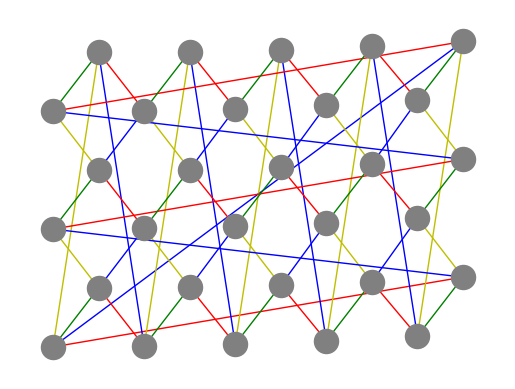

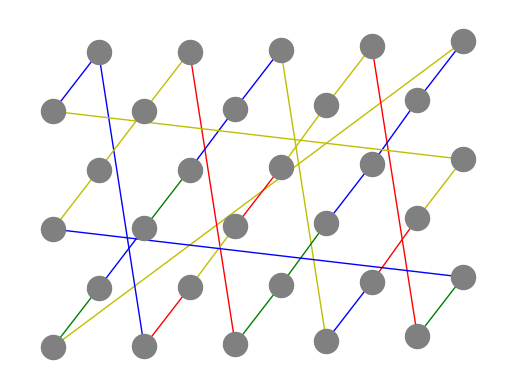

In [1]:
import networkx as nx
import numpy as np
import os
import random
import math
import matplotlib.pyplot as plt
import imageio.v2 as imageio

#initializing the graph
grid_x = 6
grid_y = 10
G = nx.triangular_lattice_graph(m = grid_x, n = grid_y, periodic=True, with_positions=True, create_using=None)
for (w, x), (y, z) in G.edges:
    if (x == z):
        G.remove_edge((w, x), (y, z))

#computing probabilities from interaction energies between edges
R = 8.314 # J/mol
T = 300 #Kelvin
E1 = -611.236*1000/(R*T) #g
E2 = -398.779*1000/(R*T) #y
E3 = -367.681*1000/(R*T) #r
E4 = -523.476*1000/(R*T) #b
E_correction = 0*1000/(R*T)

#assigning energies to the edges
for ((w, x), (y, z)) in G.edges():
    if x == 0:
        x_max = max(w, x)
    if y == 0:
        y_max = max(y, z)

for j in range(0, y_max + 1, 2):
    for i in range(x_max + 1):
        if (1 + i) == (x_max + 1):
            G[(0 + i, 1 + j)][(0, 0 + j)]['weight'] = E3
            G[(0 + i, 1 + j)][(0, 0 + j)]['color'] = 'r'
            if (2 + j) == (y_max + 1):
                G[(0 + i, 1 + j)][(0, 0)]['weight'] = E4
                G[(0 + i, 1 + j)][(0, 0)]['color'] = 'b'
            else:
                G[(0 + i, 1 + j)][(0, 2 + j)]['weight'] = E4
                G[(0 + i, 1 + j)][(0, 2 + j)]['color'] = 'b'
        else:
            G[(0 + i, 1 + j)][(1 + i, 0 + j)]['weight'] = E3
            G[(0 + i, 1 + j)][(1 + i, 0 + j)]['color'] = 'r'
            if (2 + j) == (y_max + 1):
                G[(0 + i, 1 + j)][(1 + i, 0)]['weight'] = E4
                G[(0 + i, 1 + j)][(1 + i, 0)]['color'] = 'b'
            else:
                G[(0 + i, 1 + j)][(1 + i, 2 + j)]['weight'] = E4
                G[(0 + i, 1 + j)][(1 + i, 2 + j)]['color'] = 'b'
        G[(0 + i, 1 + j)][(0 + i, 0 + j)]['weight'] = E1
        G[(0 + i, 1 + j)][(0 + i, 0 + j)]['color'] = 'g'
        if (2 + j) == (y_max + 1):
            G[(0 + i, 1 + j)][(0 + i, 0)]['weight'] = E2
            G[(0 + i, 1 + j)][(0 + i, 0)]['color'] = 'y'
        else:
            G[(0 + i, 1 + j)][(0 + i, 2 + j)]['weight'] = E2
            G[(0 + i, 1 + j)][(0 + i, 2 + j)]['color'] = 'y'

weights = [G[u][v]['weight'] for u, v in G.edges()]
colors = [G[u][v]['color'] for u,v in G.edges()]

#plot the initial graph
plt.subplot(111)
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, edge_color=colors, node_color = 'grey')
plt.show()

#calculate initial partition function
total_sum = 0
for weight in range(len(weights)):
    total_sum += math.exp(weights[weight])

#initialize fragmentation
i = 0
total_nodes = len(list(G.nodes))
empty_nodes = []
filenames = []

#run fragmentation
for i in range(total_nodes*200):
    graph_list_nodes = list(G.nodes)
    graph_list_edges = list(G.edges)

    num1 = random.randint(1, len(graph_list_edges) - 1)

    weights = [G[u][v]['weight'] for u, v in G.edges()]
    if (total_sum <= 0):
        for weight in range(len(weights)):
            total_sum += math.exp(weights[weight])
    proxy = math.exp(list(G.edges(data=True))[num1][2]['weight'])
    probability = (math.exp(list(G.edges(data=True))[num1][2]['weight']))/(total_sum)

    weight_color = (list(G.edges(data=True))[num1][2]['color'])
    threshold = random.uniform(0, 1)

    #breaking an edge
    if (1 - probability) <= threshold:
        total_sum += -(math.exp(list(G.edges(data=True))[num1][2]['weight']))
        G.remove_edge(graph_list_edges[num1][0], graph_list_edges[num1][1])
            
        plt.subplot(111)
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw(G, pos = pos, with_labels = False)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        filename = f'{i}.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()

        node1 = graph_list_edges[num1][0]
        node2 = graph_list_edges[num1][1]

        #recalculating the partition function
        for node1_neighbor in list(G.neighbors(node1)):
            total_sum += -math.exp(G.edges[node1, node1_neighbor]['weight'])
            G.edges[node1, node1_neighbor]['weight'] = (G.edges[node1, node1_neighbor]['weight']) + E_correction
            total_sum += math.exp(G.edges[node1, node1_neighbor]['weight'])
        
        for node2_neighbor in list(G.neighbors(node2)):
            total_sum += -math.exp(G.edges[node2, node2_neighbor]['weight'])
            G.edges[node2, node2_neighbor]['weight'] = (G.edges[node2, node2_neighbor]['weight']) + E_correction
            total_sum += math.exp(G.edges[node2, node2_neighbor]['weight'])
    
    for n in G.nodes:
        if len(list(G.neighbors(n))) == 0:
            if n in empty_nodes:
                ;
            else:
                empty_nodes += [n]

    #fragmentation threshold    
    if len(empty_nodes) >= (total_nodes/3):
        break

with imageio.get_writer('mygif2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)

plt.subplot(111)
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, edge_color=colors, node_color = 'grey')
plt.show()
